In [1]:
# Notebook for developing new code, changes often
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, epsilon_0
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
try:
    plt.style.use("huntstone")
except:
    plt.style.use("seaborn-colorblind")
inv_c = 1/c
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, "/Users/keenan/Documents/GitHub/plasma-source/khuntstone/eos_bpm/python/")
sys.path.insert(0, "/home/keenan/plasma-source/khuntstone/eos_bpm/python/")
# Custom modules
from crystal import crystal
import currents as cp
import eo_signal as eos
from laser import laser
import phase_retard as pr
import plotting as pl
import thz

import ipywidgets as widgets
from IPython.display import clear_output
outs = widgets.Output()
import time
cpath = "/mnt/md0/Data/currents/"
#peak_sigs      = np.load("peakSignals.npy")
#peak_drive_sig = peak_sigs[0]
#peak_wit_sig   = peak_sigs[1]

In [2]:
# Testing 1mm ZnTe for first optomizeing signal
ctype  = "znte"
d      = 100e-6
y0     = 800e-9
tp     = 45e-15
nslice = 100
dtau   = 30
tau    = np.arange(-500, 1000+dtau, dtau)*1e-15
setup  = {"ctype"   : ctype,
         "d"       : d,
         "y0"      : y0,
         "tp"      : tp,
         "nslice"  : nslice,
         "method"  : "spatial",
         "process" : "cross", 
         "r0"      : 2.5e-3,
         "fpath"   : cpath,
         "tau"     : tau,
         "angle"   : 15}

In [3]:
sig, tsig = eos.get_signal(10, setup)
I, ti, p2p = cp.get_current(10, cpath)

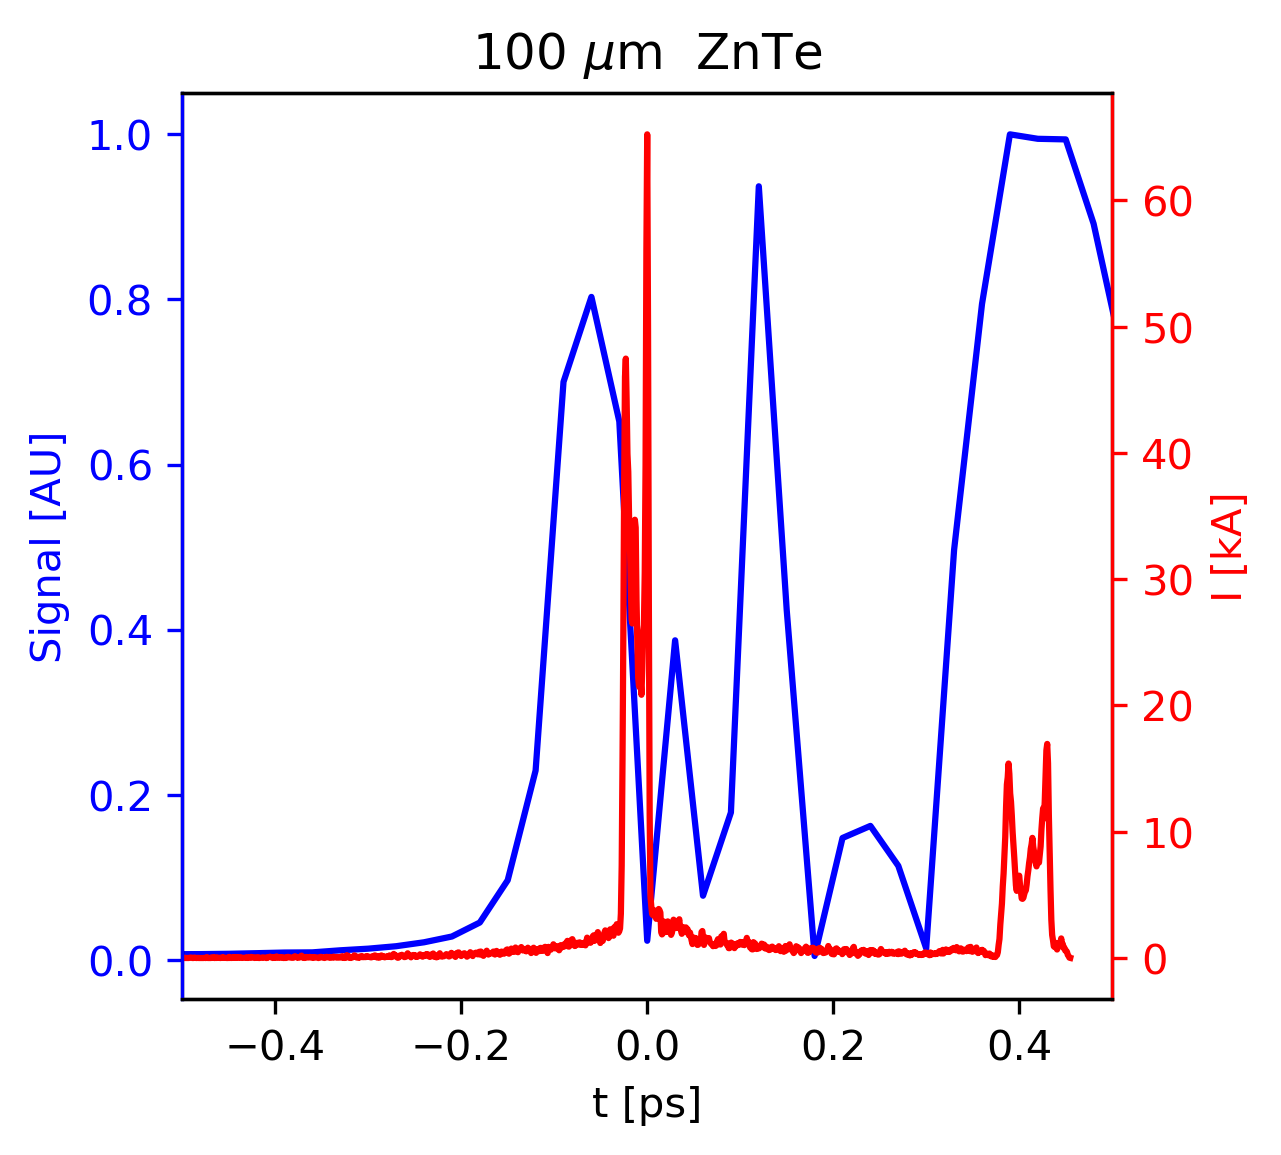

In [4]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax1  = fig.gca()
ax1.set_xlabel("t [ps]")
ax1.set_ylabel("Signal [AU]", color = "blue")
ax1.tick_params(axis = "y", color = "b", labelcolor = "blue")
ax1.plot(tsig*1e12, sig/max(sig), '-b')
ax2 = ax1.twinx()
ax2.set_ylabel("I [kA]", color = "r")
ax2.spines["left"].set_color("b")
ax2.spines["right"].set_color("r")
ax2.tick_params(axis = "y", color = "r", labelcolor = "r")
ax2.plot(ti*1e12, I, '-r')
ax2.set_xlim([-0.5, 0.5])
ax2.set_title(r'100 $\mu$m  ZnTe')
plt.show()
#ax2  = ax1.twinx()

In [15]:
# Test ZnTe for single bunch
from scipy.constants import c, epsilon_0
eps0 = epsilon_0
Q    = 0.4e-12
sigz = 50e-6
r0   = 2.5e-3
sigt = sigz/c
E0   = Q / ((2*np.pi)**(1.5)*sigt*epsilon_0*r0*c)
dt   = sigt*0.1
N    = 8000
te   = np.linspace(-N*dt*0.5, N*dt*0.5, N)
E    = E0 * np.exp(-te*te/(2*sigt*sigt))
setup["d"] = 1e-3
setup["ctype"] = "znte"
print(setup["ctype"], setup["d"])
setup["tau"] = te
sig_z, tsig_z, gamma, tgamma = eos.E_signal(E, te, setup)
setup["d"] = 100e-6
setup["ctype"] = "gap"
print(setup["ctype"], setup["d"])
sig_g, tsig_g, gamma, tgamma = eos.E_signal(E, te, setup)

znte 0.001
gap 0.0001


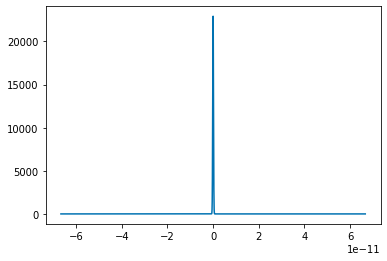

In [16]:
plt.plot(te, E)
plt.show()

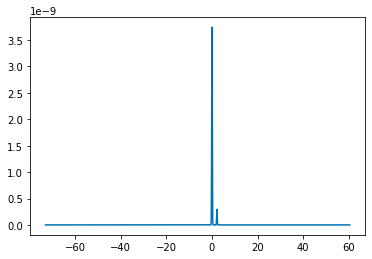

In [17]:
plt.plot(tsig_g*1e12, sig_g)
plt.show()

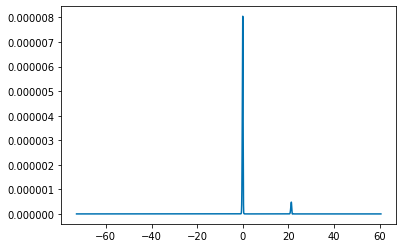

In [18]:
plt.plot(tsig_z*1e12, sig_z)
plt.show()

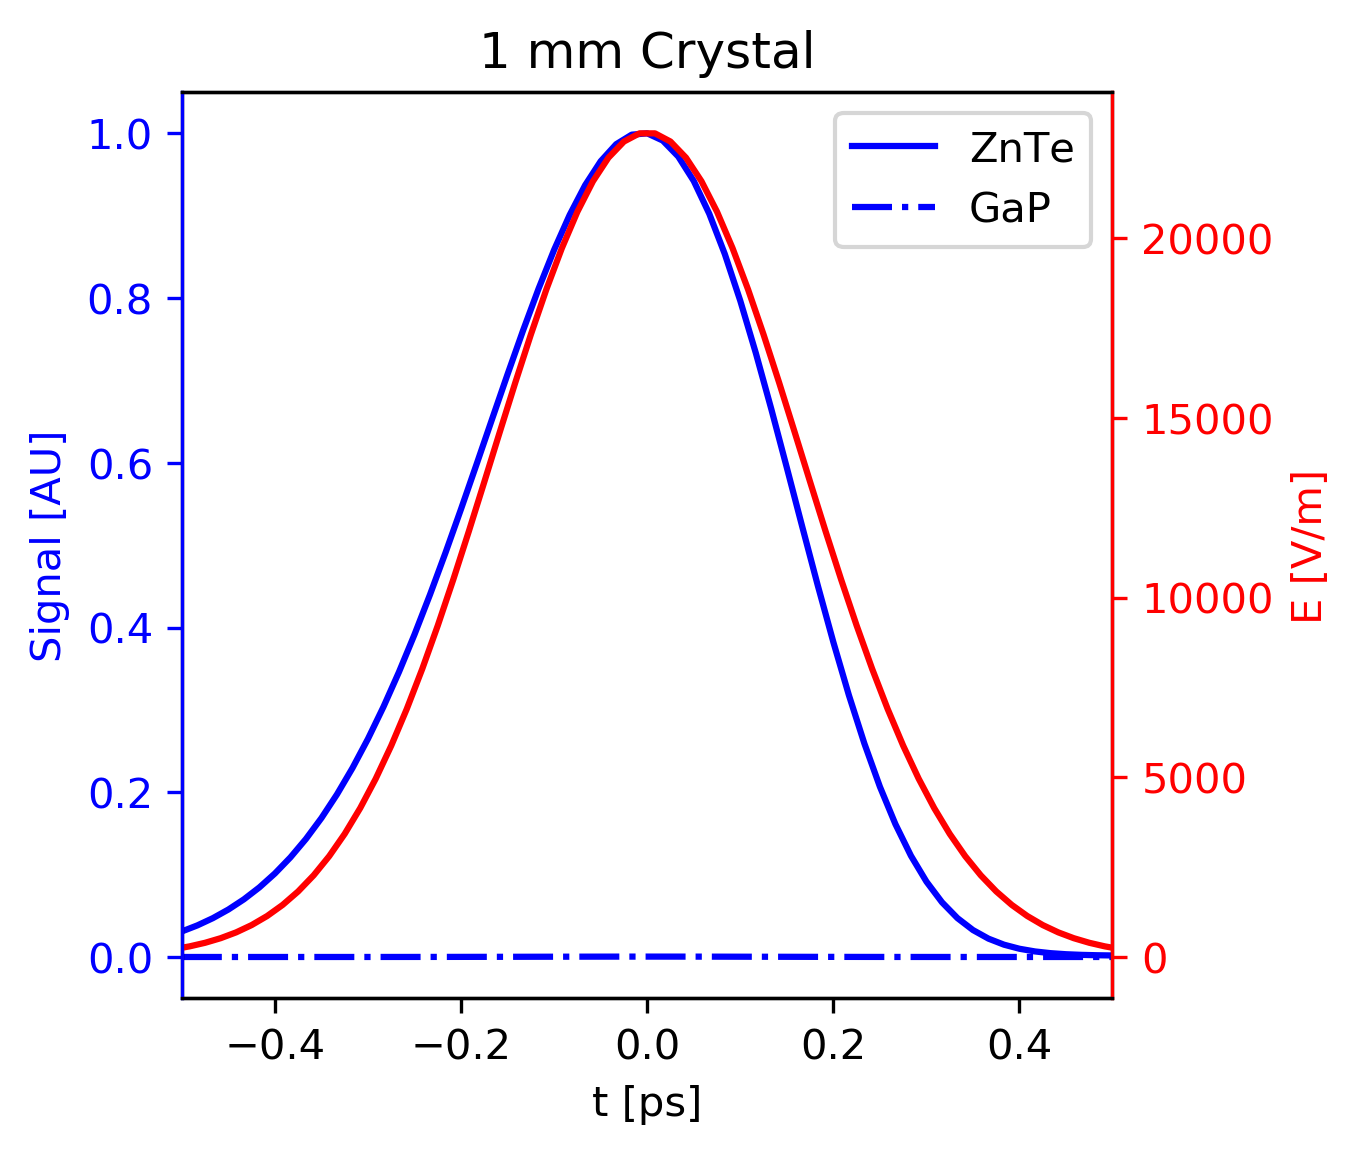

In [20]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax1  = fig.gca()
ax1.set_xlabel("t [ps]")
ax1.set_ylabel("Signal [AU]", color = "blue")
ax1.tick_params(axis = "y", color = "b", labelcolor = "blue")
ax1.plot(tsig_z*1e12, sig_z/max(sig_z), '-b', label = "ZnTe")
ax1.plot(tsig_g*1e12, sig_g/max(sig_z), '-.b', label = "GaP")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel("E [V/m]", color = "r")
ax2.spines["left"].set_color("b")
ax2.spines["right"].set_color("r")
ax2.tick_params(axis = "y", color = "r", labelcolor = "r")
ax2.plot(te*1e12, E, '-r')
ax2.set_xlim([-0.5, 0.5])
ax2.set_title(r'1 mm Crystal')
plt.show()

In [18]:
max(sig_g)

3.2665880617428094e-08

In [19]:
max(sig_z)

3.2665880617428094e-08

In [16]:
ctype  = "gap"
d      = 100e-6
y0     = 800e-9
tp     = 30e-15
nslice = 100
tchirp = 487e-15
dtau   = 30
tau    = np.arange(-1000, 1000+dtau, dtau)*1e-15

In [17]:
setup = {"ctype"   : ctype,
         "d"       : d,
         "y0"      : y0,
         "tp"      : tp,
         "nslice"  : nslice,
         "method"  : "spatial",
         "process" : "cross", 
         "r0"      : 2.5e-3,
         "fpath"   : cpath,
         "tau"     : tau,
         "angle"   : 15}

In [18]:
def getE(Q, sigt, r0, te):
    E0 = Q / ((2*np.pi)**(1.5)*r0*c*epsilon_0*sigt)
    return E0 * np.exp(-te*te/(2*sigt*sigt))

In [70]:
sigz = 50e-6
sigt = sigz / c
N    = 8000
dt   = sigt*0.1
te   = np.linspace(-N*0.5*dt, N*0.5*dt, N)
dx   = 10e-6
rp   = 2.5e-3 + dx
rm   = 2.5e-3 - dx
Qs   = np.linspace(400e-12, 1.5e-9, 100)
sig_zs = np.linspace(15, 50, 100)*1e-6
gammas = np.zeros((len(Qs), len(sig_zs)))
setup["tau"] = te
upd = int(len(Qs)/10)
for i in range(len(Qs)):
    if upd != 0 and (i+1)%upd ==0:
        print(i+1, "of", len(sig_zs))
    else:
        print(i+1)
    Q    = Qs[i]
    for j in range(len(sig_zs)):
        sigt = sig_zs[j]/c
        E    = getE(Q, sigt, 2.5e-3, te)
        sig, tsig, gamma, tgamma = eos.E_signal(E, te, setup)
        gammas[i, j] = max(gamma)

1
2
3
4
5
6
7
8
9
10 of 100
11
12
13
14
15
16
17
18
19
20 of 100
21
22
23
24
25
26
27
28
29
30 of 100
31
32
33
34
35
36
37
38
39
40 of 100
41
42
43
44
45
46
47
48
49
50 of 100
51
52
53
54
55
56
57
58
59
60 of 100
61
62
63
64
65
66
67
68
69
70 of 100
71
72
73
74
75
76
77
78
79
80 of 100
81
82
83
84
85
86
87
88
89
90 of 100
91
92
93
94
95
96
97
98
99
100 of 100


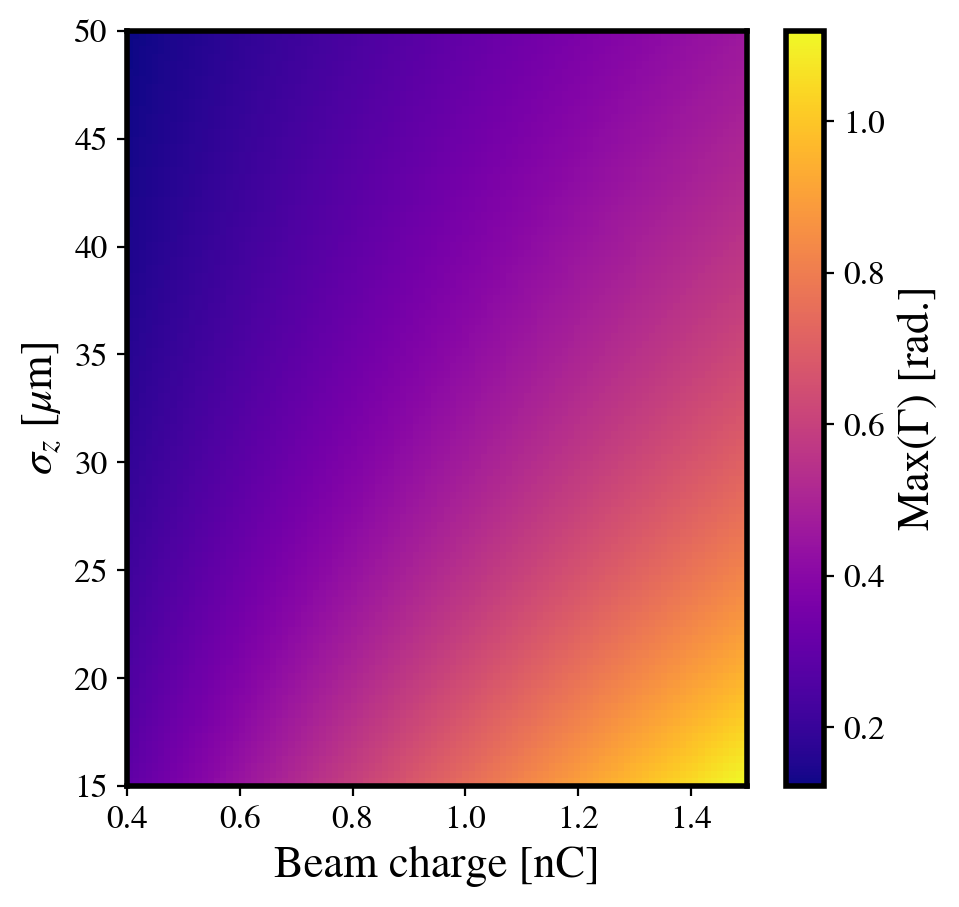

In [71]:
fig = plt.figure(figsize = (5,5), dpi = 200)
ax  = fig.gca()
ext = [min(Qs*1e9), max(Qs*1e9), min(sig_zs*1e6), max(sig_zs*1e6)]
ax.set_xlabel("Beam charge [nC]")
ax.set_ylabel(r'$\sigma_z$ [$\mu$m]')
img = ax.imshow(np.transpose(np.fliplr(gammas)), aspect = "auto", extent = ext, cmap = "plasma")
cbar = plt.colorbar(mappable = img)
cbar.set_label(r'Max($\Gamma$) [rad.]')
plt.show()

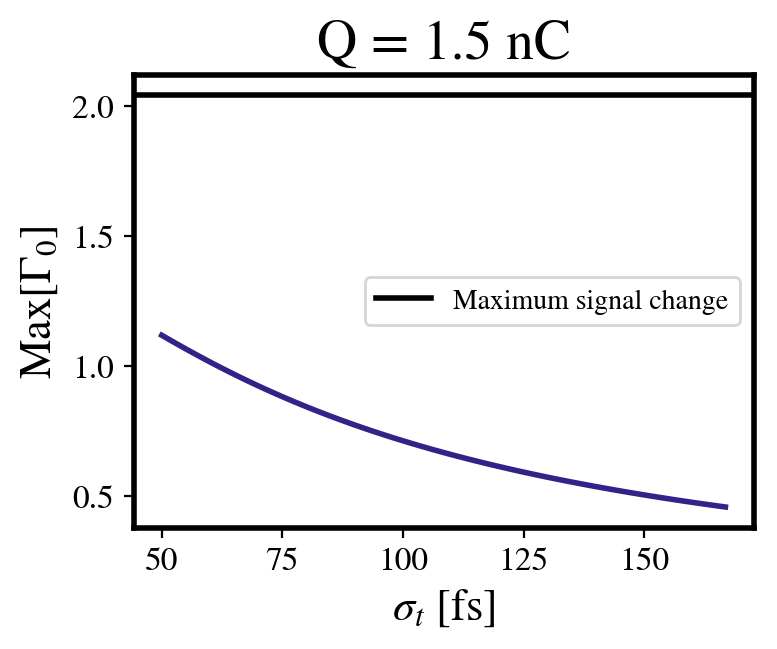

In [58]:
fig = plt.figure(figsize = (4,3),dpi = 200)
ax  = fig.gca()
ax.set_xlabel(r'$\sigma_t$ [fs]')
ax.set_ylabel(r'Max[$\Gamma_0$]')
ax.plot(sig_zs/c*1e15, gammas, '-')
ax.set_title("Q = 1.5 nC")
ax.axhline(y = 0.65*np.pi, color = "k", label = "Maximum signal change")
ax.legend()
plt.show()

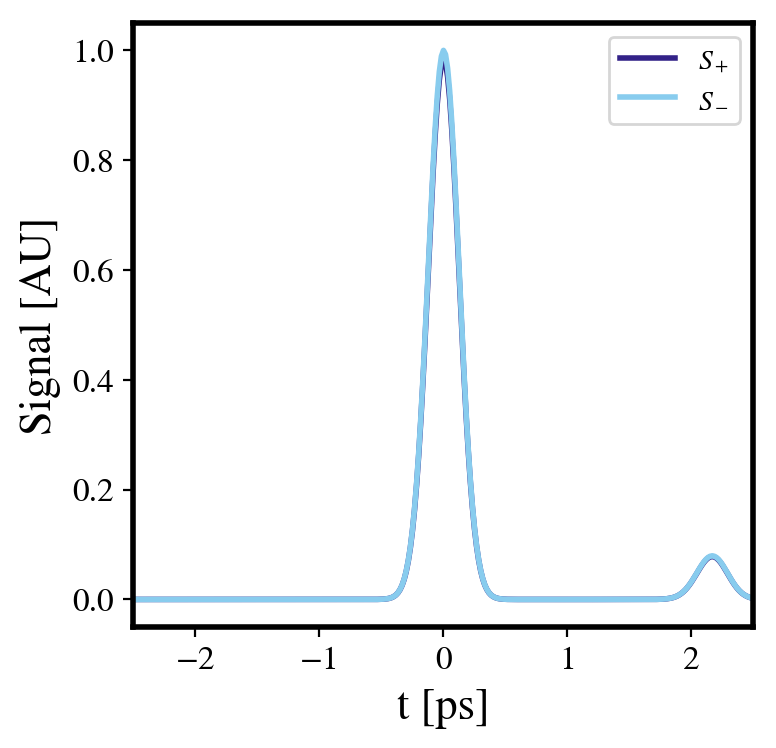

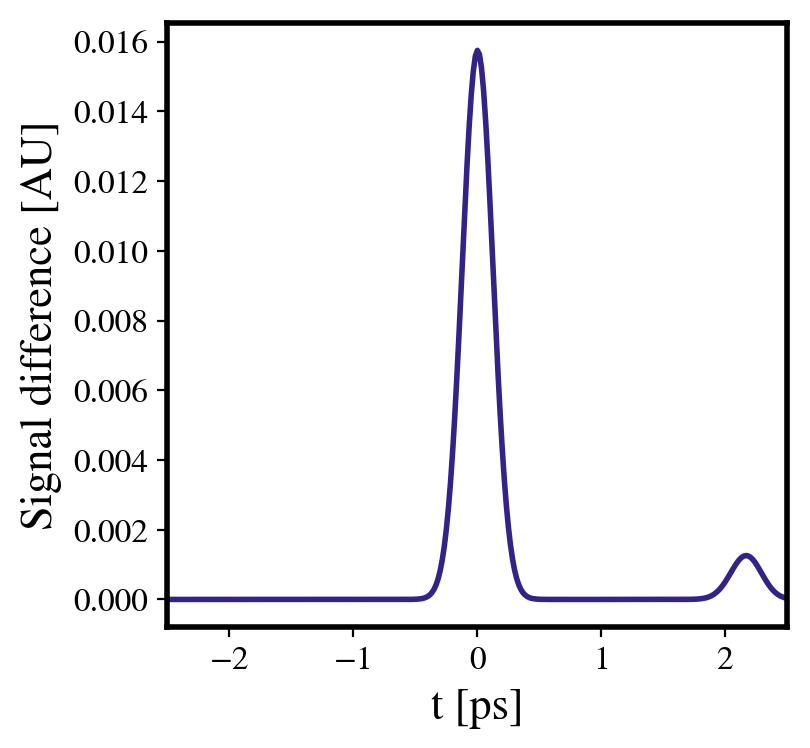

In [40]:
fig1 = plt.figure(figsize = (4,4), dpi = 200)
ax1  = fig1.gca()
ax1.plot(tsigp*1e12, sigp/max(sigm), '-', label = r'$S_+$')
ax1.plot(tsigm*1e12, sigm/max(sigm), '-', label = r'$S_-$')
ax1.set_xlabel('t [ps]')
ax1.set_ylabel('Signal [AU]')
ax1.legend()
ax1.set_xlim([-2.5, 2.5])
plt.show()

fig2 = plt.figure(figsize = (4,4), dpi = 200)
ax2  = fig2.gca()
ax2.plot(tsigp*1e12, (sigm - sigp)/max(sigm))
ax2.set_xlabel("t [ps]")
ax2.set_ylabel("Signal difference [AU]")
ax2.set_xlim([-2.5, 2.5])
plt.show()

In [72]:
#max_dI = np.zeros(3135)
#max_wI = np.zeros(3135)
#for i in range(3135):
#    if (i+1)%500==0:
#        print(i+1, "of 3135")
#    I, ti, p2p = cp.get_current(i, cpath)
#    w_ind = np.argmin(abs(ti - 250e-15))
#    max_dI[i] = max(I[0:w_ind])
#    max_wI[i] = max(I[w_ind:-1])
#np.save("peakCurrent.npy", [max_dI, max_wI])
peakIs = np.load("peakCurrent.npy")
max_dI = peakIs[0]
max_wI = peakIs[1]

In [8]:
N_prof = 3135
avg_peaks_d   = np.zeros(N_prof)
avg_peaks_w   = np.zeros(N_prof) 
avg_range_d   = np.zeros(N_prof) 
avg_range_w   = np.zeros(N_prof)
avg_mid_d     = np.zeros(N_prof)
avg_mid_w     = np.zeros(N_prof)
avg_dbl_d     = np.zeros(N_prof)
avg_dbl_w     = np.zeros(N_prof)

multi_w_ind   = np.zeros(N_prof) + False
multi_d_ind   = np.zeros(N_prof) + False
for ind in range(N_prof):
    if (ind+1)%500==0:
        print(ind+1, "of", N_prof)
    I, ti, p2p = cp.get_current(ind, cpath)
    w_ind      = np.argmin(abs(ti - 250e-15))
    max_drive  = max(I[0:w_ind])
    max_wit    = max(I[w_ind:-1])
    # Get peak locations
    dlocs, dpeaks = find_peaks(I[0:w_ind], height=0.2*max_drive, prominence=10)
    wlocs, wpeaks = find_peaks(I[w_ind:-1], height=0.2*max_wit, prominence=10)
    wlocs = wlocs + w_ind
    # Average if multi-peaked
    if len(dlocs) > 1:
        multi_d_ind[ind] = True
        d1 = dlocs[0]
        d2 = dlocs[-1]
        avg_range_d[ind] = np.mean(I[d1:d2])
        avg_peaks_d[ind] = np.mean(I[dlocs])
        avg_dbl_d[ind] = 0.5*(avg_range_d[ind] + avg_peaks_d[ind])
        tmid = 0.5*(ti[d2]-ti[d1])
        imid = np.argmin(abs(ti-tmid))
        avg_mid_d[ind] = I[imid]
    else:
        avg_range_d[ind] = max_drive
        avg_peaks_d[ind] = max_drive
        avg_mid_d[ind]   = max_drive
        avg_dbl_d[ind]   = max_drive
    if len(wlocs) > 1:
        multi_w_ind[ind] = True
        w1 = wlocs[0]
        w2 = wlocs[-1]
        avg_range_w[ind] = np.mean(I[w1:w2])
        avg_peaks_w[ind] = np.mean(I[wlocs])
        avg_dbl_w[ind] = 0.5*(avg_range_w[ind] + avg_peaks_w[ind])
        tmid = 0.5*(ti[w2]-ti[w1])
        imid = np.argmin(abs(ti-tmid))
        avg_mid_w[ind] = I[imid]
    else:
        avg_range_w[ind] = max_wit
        avg_peaks_w[ind] = max_wit
        avg_mid_w[ind]   = max_wit
        avg_dbl_w[ind]   = max_wit
    #print(ind, len(dlocs), len(wlocs)) 

500 of 3135
1000 of 3135
1500 of 3135
2000 of 3135
2500 of 3135
3000 of 3135


In [9]:
def lin_func(x, m, b):
    return m*x+b

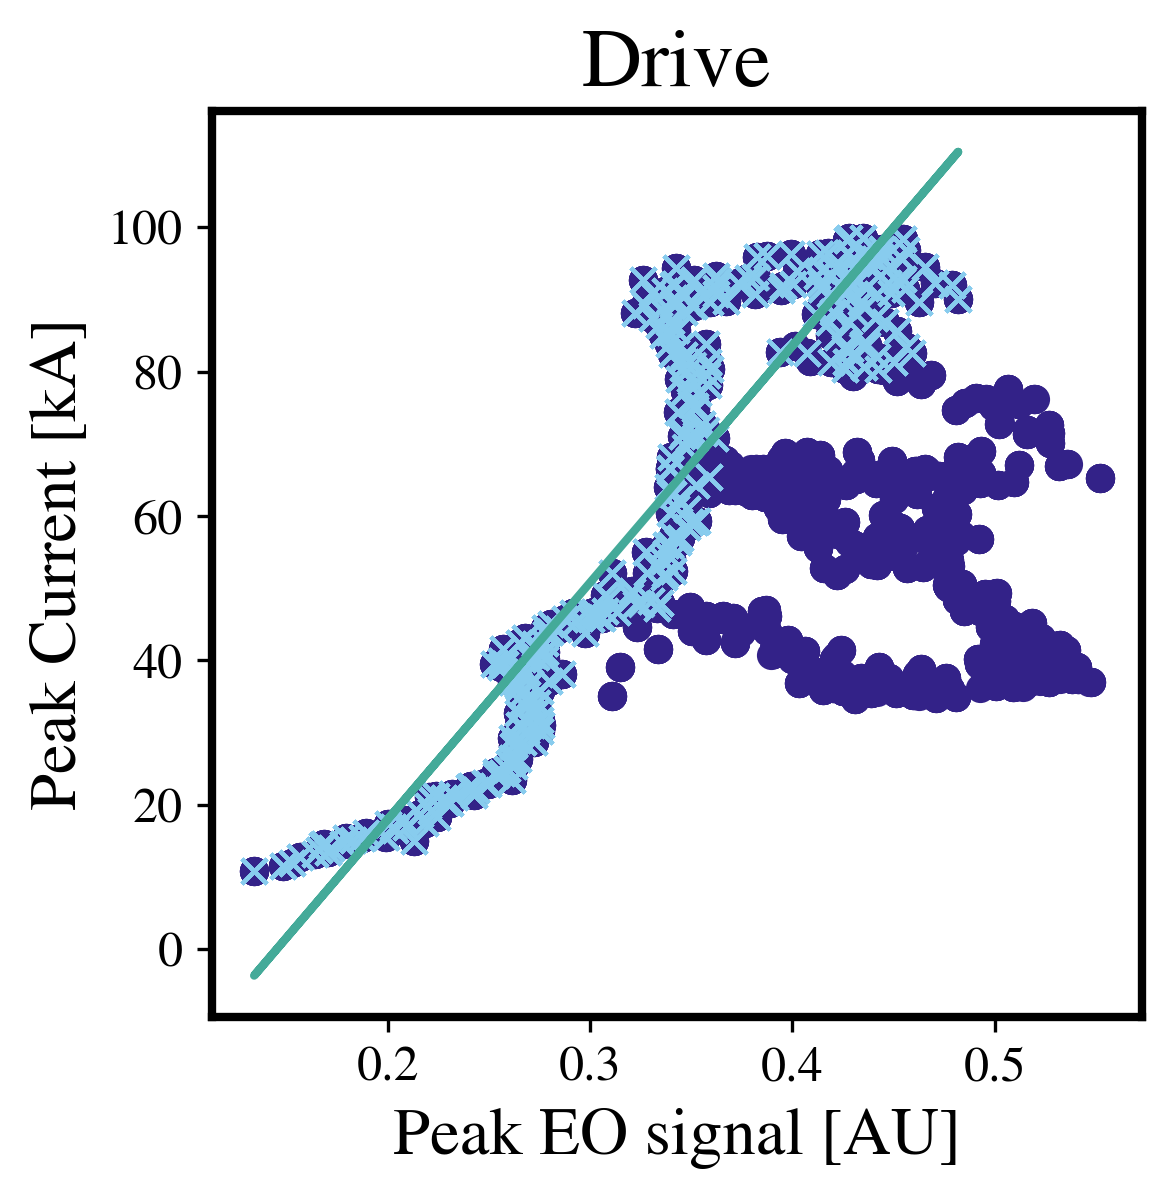

327.7102055908282 -47.49900104647641


In [12]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Peak EO signal [AU]")
ax.set_ylabel("Peak Current [kA]")
ax.set_title("Drive")
#ax.plot(peak_drive_sig, max_dI, 'o')
good_sigs = -1*peak_drive_sig * (multi_d_ind-1)
good_sigs[good_sigs==0]=np.nan
inds = ~np.isnan(good_sigs)
max_dI_good = max_dI[inds]
peak_sig_good = good_sigs[inds]
popt, pcov = curve_fit(lin_func, peak_sig_good, max_dI_good)
ax.plot(peak_drive_sig, max_dI, 'o')
ax.plot(peak_sig_good, max_dI_good, 'x')
ax.plot(peak_sig_good, lin_func(peak_sig_good, *popt), '-')
plt.show()
print(popt[0], popt[1])

In [13]:
ym = 1/popt[0]
yb = popt[1]/popt[0]
print(ym, yb)

0.0030514765269427655 -0.1449420867465526


In [21]:
inds = np.argwhere(multi_d_ind==1)
sig_act = np.zeros(len(inds))
sig_pre = np.zeros(len(inds))
t_dur = np.zeros(len(inds))
upds = int(len(inds)/10)
for i in range(len(inds)):
    if (i+1)%upds==0:
        print(i+1, "of", len(inds))
    I, ti, p2p = cp.get_current(np.squeeze(inds[i]), cpath)
    w_ind = np.argmin(abs(ti-250e-15))
    max_drive = max(I[0:w_ind])
    dlocs, dpeaks = find_peaks(I[0:w_ind], height=0.2*max_drive, prominence=10)
    t_dur[i]   = ti[dlocs[-1]] - ti[dlocs[0]]
    sig_act[i] = peak_drive_sig[inds[i]]
    sig_pre[i] = ym*max_drive - yb

161 of 1618
322 of 1618
483 of 1618
644 of 1618
805 of 1618
966 of 1618
1127 of 1618
1288 of 1618
1449 of 1618
1610 of 1618


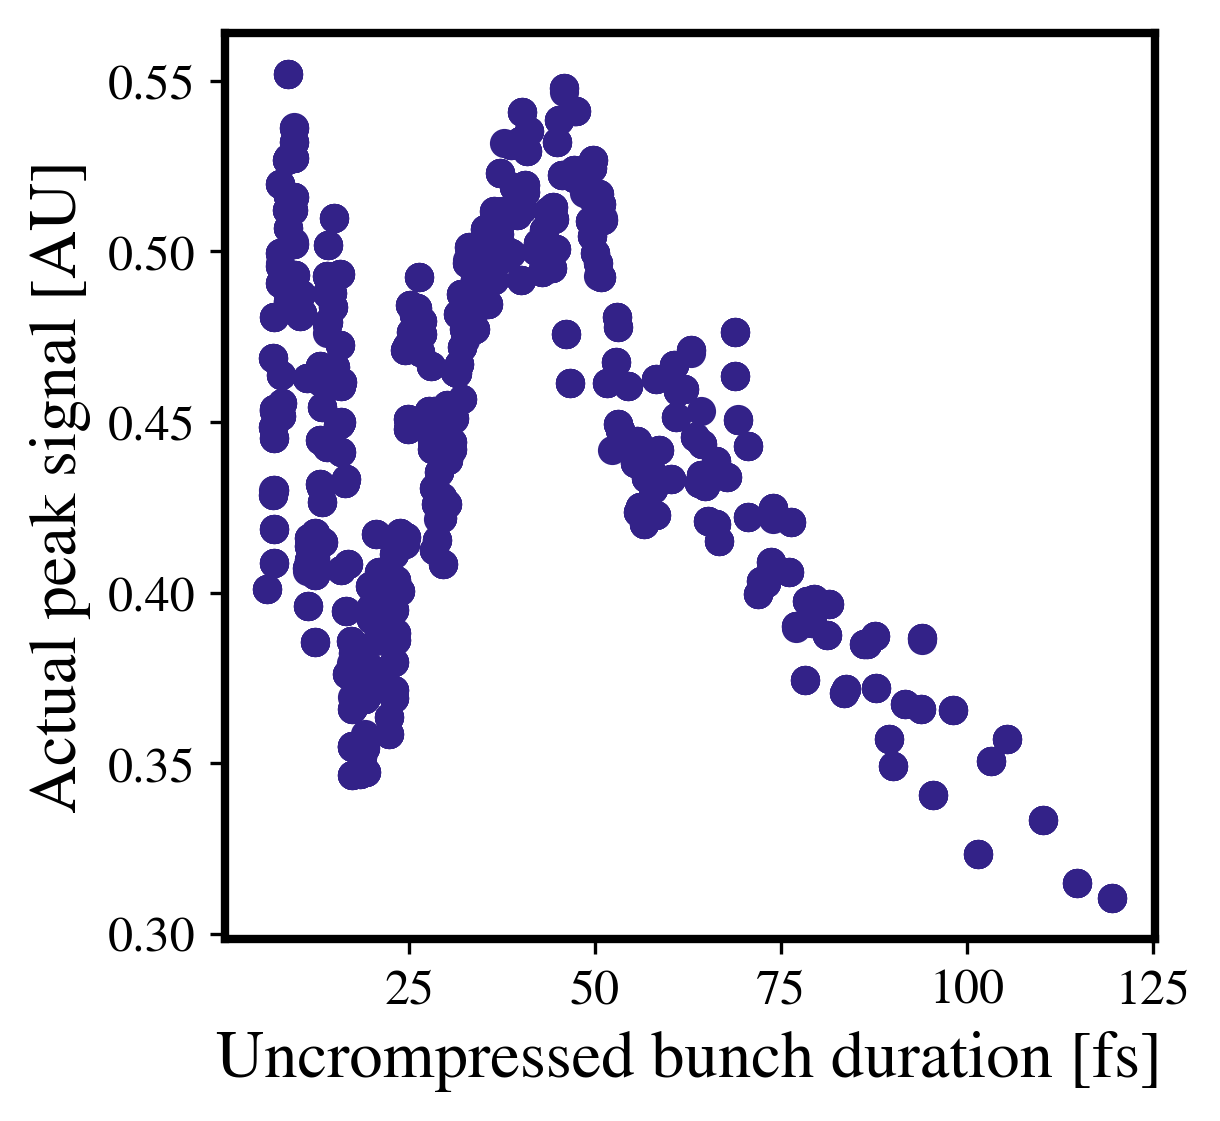

In [22]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Uncrompressed bunch duration [fs]")
ax.set_ylabel("Actual peak signal [AU]")
ax.plot(t_dur*1e15, sig_act, 'o')
plt.show()

In [130]:
min(t_dur*1e15)

5.864613916171856

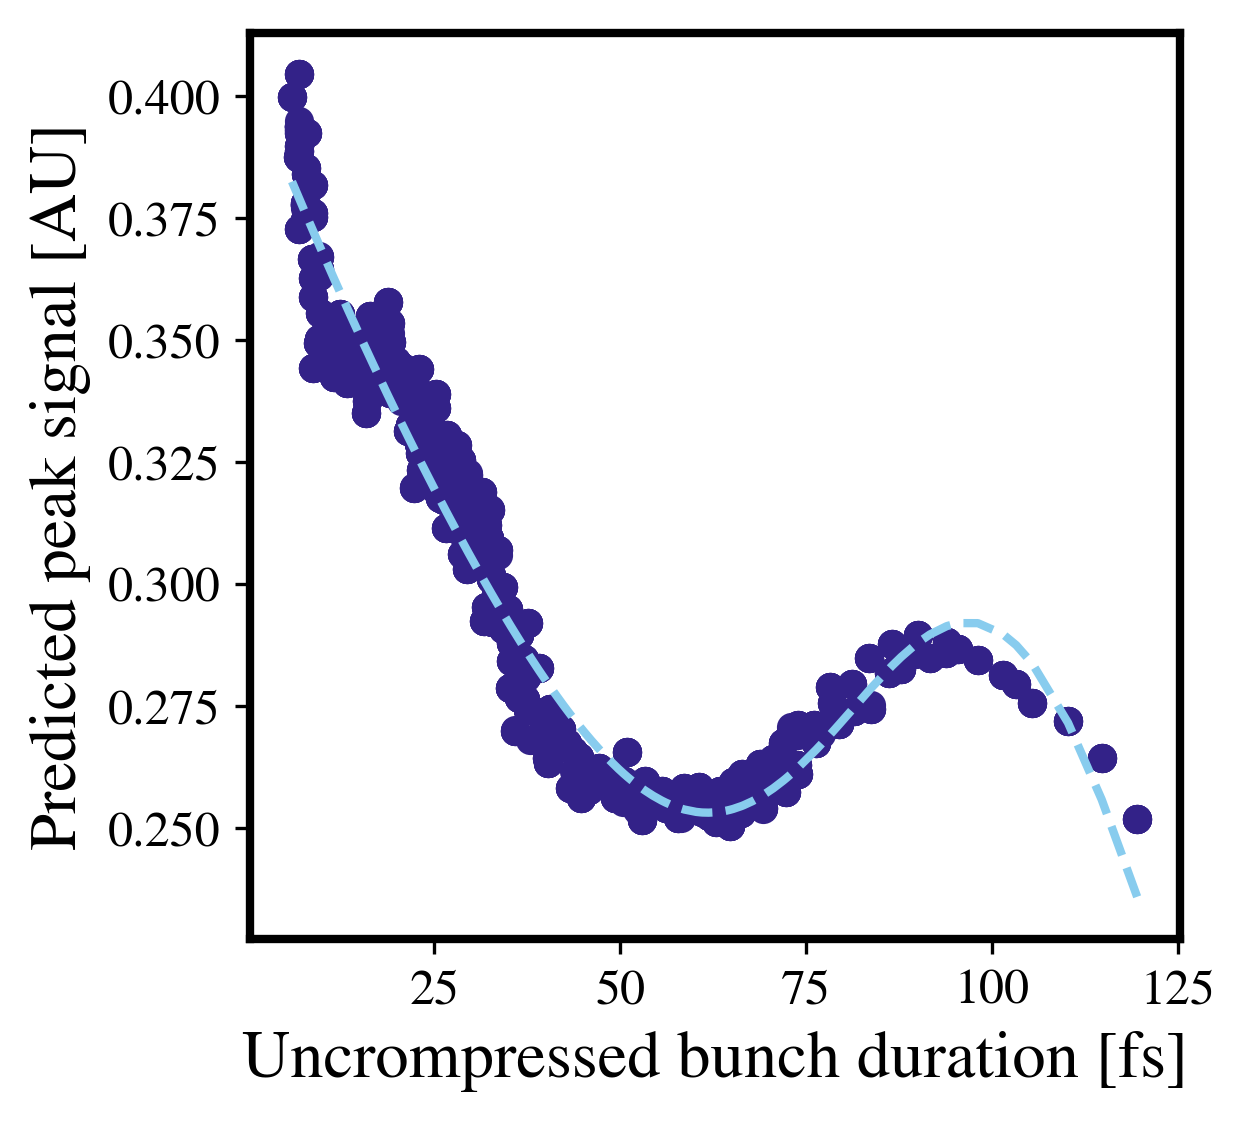

In [132]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Uncrompressed bunch duration [fs]")
ax.set_ylabel("Predicted peak signal [AU]")
ax.plot(t_dur*1e15, sig_pre, 'o')
xdata = t_dur*1e15
isort = sorted(range(len(xdata)), key=lambda k: xdata[k])
xfit = xdata[isort]
yfit = sig_pre[isort]
poptp, pcovp = curve_fit(dbl_gauss, xfit, yfit)
ax.plot(xfit, dbl_gauss(xfit, *poptp), '--')
plt.show()

In [112]:
# Fitting functions for signal boost
def dbl_gauss(x, a, b, c, d, f, g):
    return a*np.exp(-(x-b)*2/c**2)+d*np.exp(-(x-f)**2/g**2)
def long_tail(x, a, b, c):
    return (a*x+b)*np.exp(-c*x)

/home/keenan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


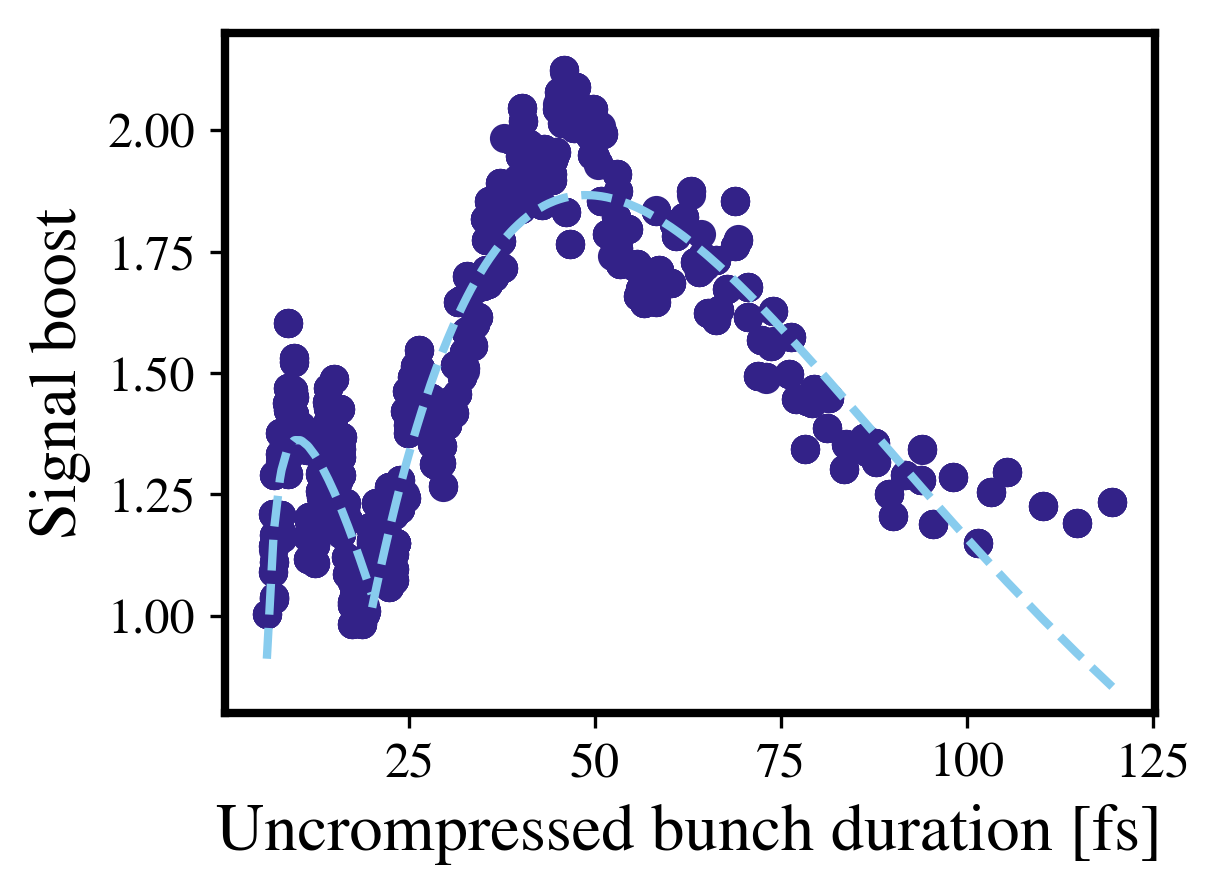

In [125]:
fig = plt.figure(figsize = (4,3), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Uncrompressed bunch duration [fs]")
ax.set_ylabel("Signal boost")
ax.plot(t_dur*1e15, sig_act/sig_pre, 'o')
xdata = t_dur*1e15
isort = sorted(range(len(xdata)), key=lambda k: xdata[k])
xdata = xdata[isort]
ydata = (sig_act/sig_pre)[isort]
ind1  = np.argmin(abs(xdata-20))
xfit1  = xdata[0:ind1]
yfit1  = ydata[0:ind1]
xfit2  = xdata[ind1:-1]
yfit2  = ydata[ind1:-1]
p01 = [1.6, 8, 0.25, 1.5, 15, 0.25]
popt1, pcov1 = curve_fit(dbl_gauss, xfit1, yfit1, p01)
p02 = [50, -89, 0.4]
popt2, pcov2 = curve_fit(long_tail, xfit2, yfit2, p02)
ax.plot(xfit1, dbl_gauss(xfit1, *popt1), '--')
ax.plot(xfit2, long_tail(xfit2, *popt2), '--', color = ax.lines[-1].get_color())
ax.set_ylim([0.8, 2.2])
plt.show()

In [89]:
N_prof = 3135
mod_sig = np.zeros(N_prof)
mod_ind = np.zeros(N_prof)
int_cur_d = np.zeros(N_prof)
int_cur_w = np.zeros(N_prof)
upds = int(N_prof/10)
for ind in range(N_prof):
    if (ind+1)%upds==0:
        print(ind+1, "of", N_prof)
    I, ti, p2p     = cp.get_current(ind, cpath)
    dt             = ti[1]-ti[0]
    w_ind          = np.argmin(abs(ti - 250e-15))
    max_drive      = max(I[0:w_ind])
    int_cur_d[ind] = np.trapz(I[0:w_ind]*1e3, ti[0:w_ind]) 
    int_cur_w[ind] = np.trapz(I[w_ind:-1]*1e3, ti[w_ind:-1])
    # Get peak locations
    dlocs, dpeaks = find_peaks(I[0:w_ind], height=0.2*max_drive, prominence=10)
    # Sum if peaks are spaced far enough, average otherwise
    #if len(dlocs) > 1:
    #    mod_ind[ind] = 1
    #    tdur = np.squeeze(ti[dlocs[-1]]-ti[dlocs[0]])
    #    mod_sig[ind] = dbl_gauss(tdur*1e15, *poptp)
        #if tdur >= 25e-15:
        #    boost = max([1, long_tail(tdur*1e15, *popt2)+0.25])
        #    mod_sig[ind] = peak_drive_sig[ind] / boost
        #else:
            #boost = max([1, dbl_gauss(tdur*1e15, *popt1)])
            #mod_sig[ind] = peak_drive_sig[ind] / boost
    #else:
    #    mod_sig[ind] = peak_drive_sig[ind]
print("Done")

313 of 3135
626 of 3135
939 of 3135
1252 of 3135
1565 of 3135
1878 of 3135
2191 of 3135
2504 of 3135
2817 of 3135
3130 of 3135
Done


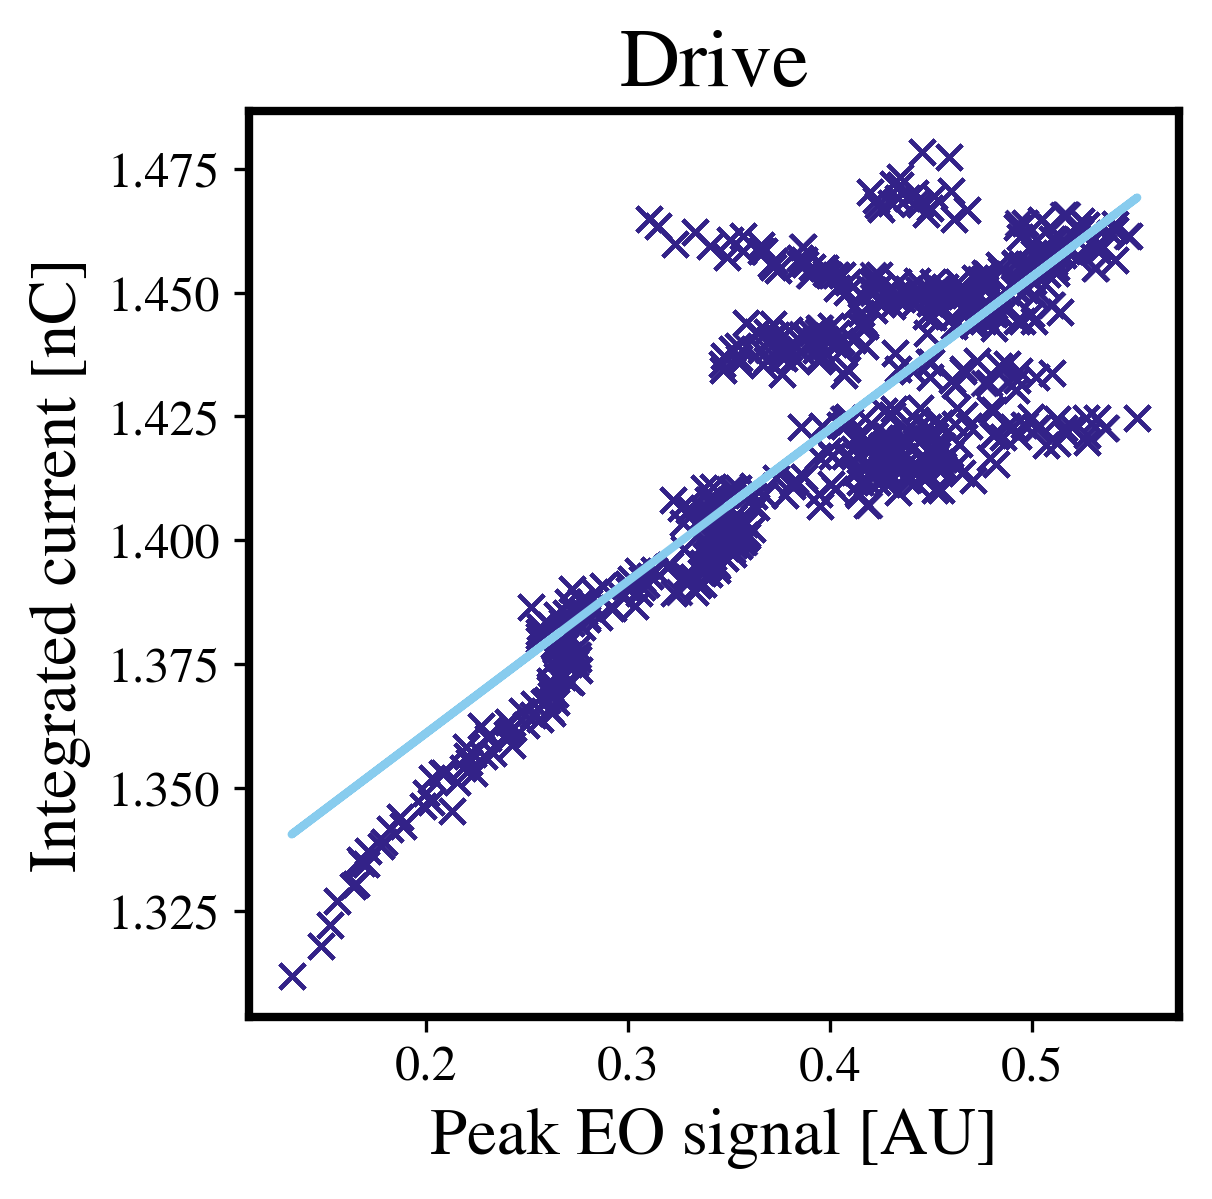

In [90]:
fig = plt.figure(figsize = (4,4), dpi=300)
ax  = fig.gca()
ax.set_xlabel("Peak EO signal [AU]")
ax.set_ylabel("Integrated current [nC]")
ax.plot(peak_drive_sig, int_cur_d*1e9, 'x')
p1, p2 = np.polyfit(peak_drive_sig, int_cur_d*1e9, deg = 1)
ax.plot(peak_drive_sig, p1*peak_drive_sig+p2)
ax.set_title("Drive")
plt.show()

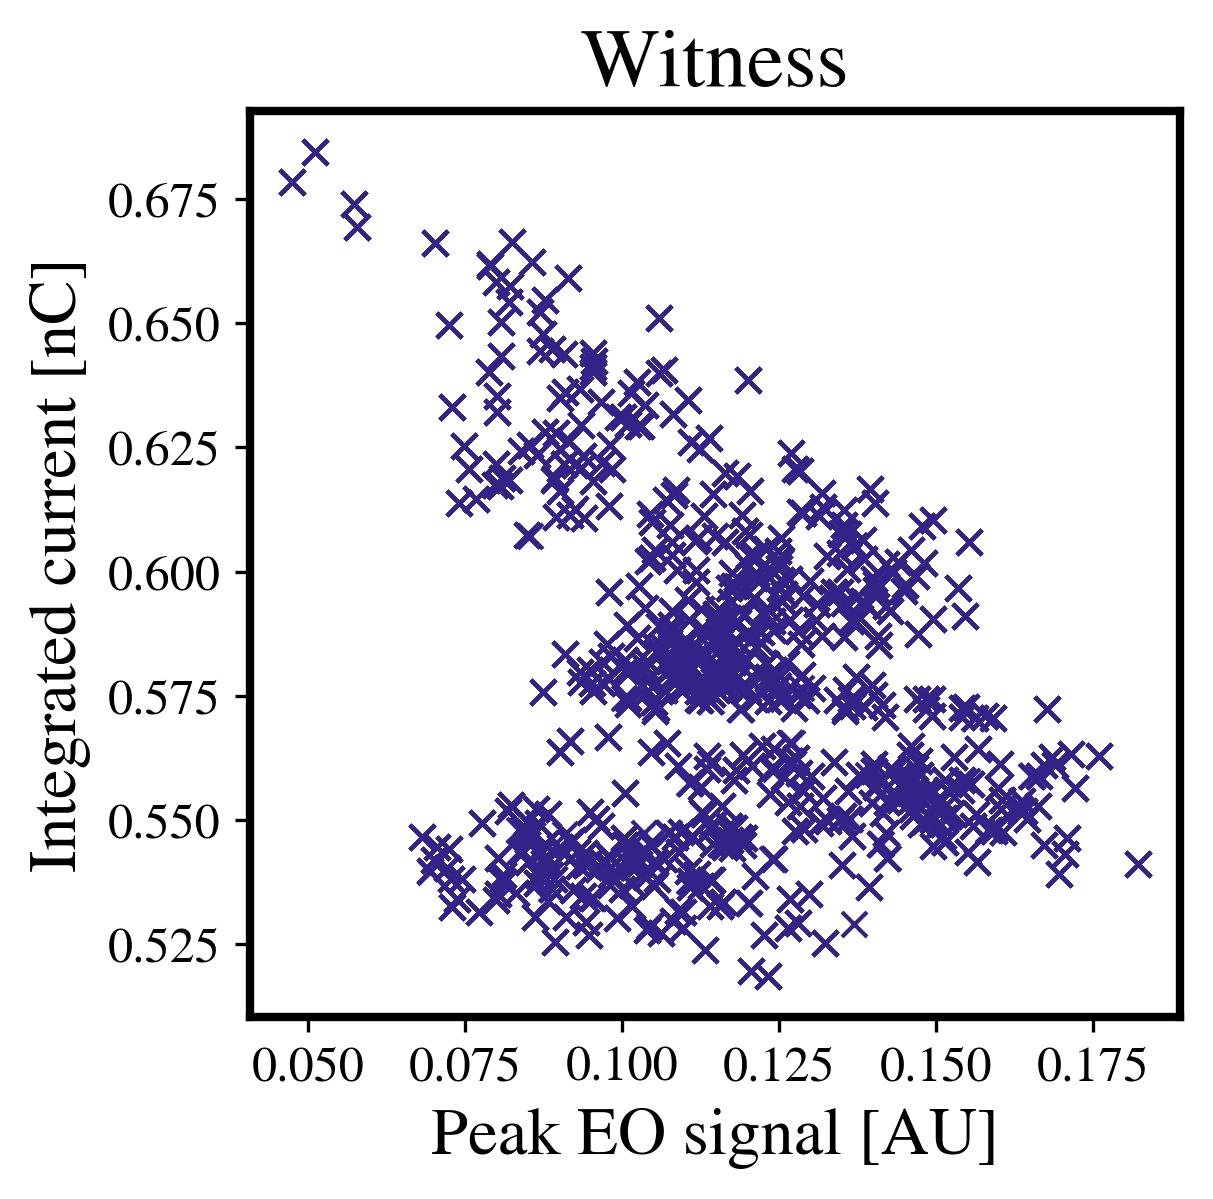

In [91]:
fig = plt.figure(figsize = (4,4), dpi=300)
ax  = fig.gca()
ax.set_xlabel("Peak EO signal [AU]")
ax.set_ylabel("Integrated current [nC]")
ax.plot(peak_wit_sig, int_cur_w*1e9, 'x')
p1, p2 = np.polyfit(peak_wit_sig, int_cur_w, deg = 1)
#ax.plot(peak_wit_sig, p1*peak_wit_sig+p2)
ax.set_title("Witness")
plt.show()

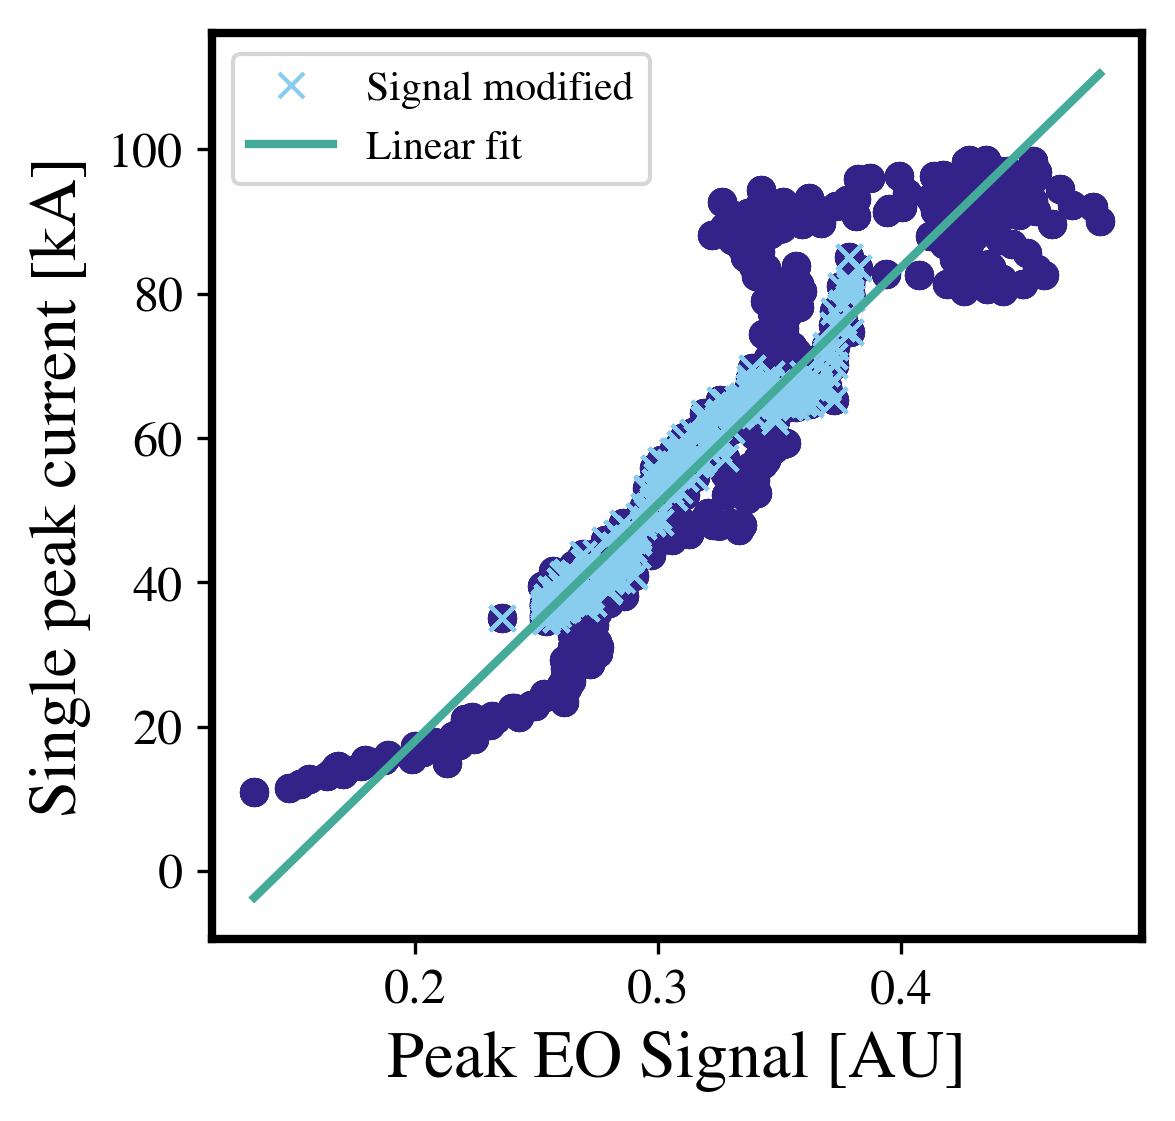

In [144]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax = fig.gca()
ax.set_xlabel("Peak EO Signal [AU]")
ax.set_ylabel("Single peak current [kA]")
mod_plot = mod_sig * mod_ind
mod_plot[mod_plot==0]=np.nan
ax.plot(mod_sig, max_dI, 'o')
ax.plot(mod_plot, max_dI, 'x', label = "Signal modified")
xdata = mod_sig
isort = sorted(range(len(xdata)), key=lambda k: xdata[k])
xdata = xdata[isort]
ydata = max_dI[isort]
p = np.polyfit(xdata, ydata, deg = 1)
ax.plot(xdata, p[1] + p[0]*xdata, '-', label = "Linear fit")
ax.legend()
plt.show()

In [381]:
def exp_func(x, a, b, c):
    return a*np.exp(x/b)-c

# Fit the drive bunch
a0 = max_dI[np.argmin(peak_drive_sig)]
b0 = 1
c0 = 1
p0 = [a0, b0, c0]
xdata = peak_drive_sig
ydata = max_dI
inds = sorted(range(len(xdata)), key=lambda k: xdata[k])
xdata = xdata[inds]
ydata = ydata[inds]
popt, pcov = curve_fit(exp_func, peak_drive_sig, max_dI, bounds = ([0, 0, 0], [np.inf, np.inf, np.inf]))

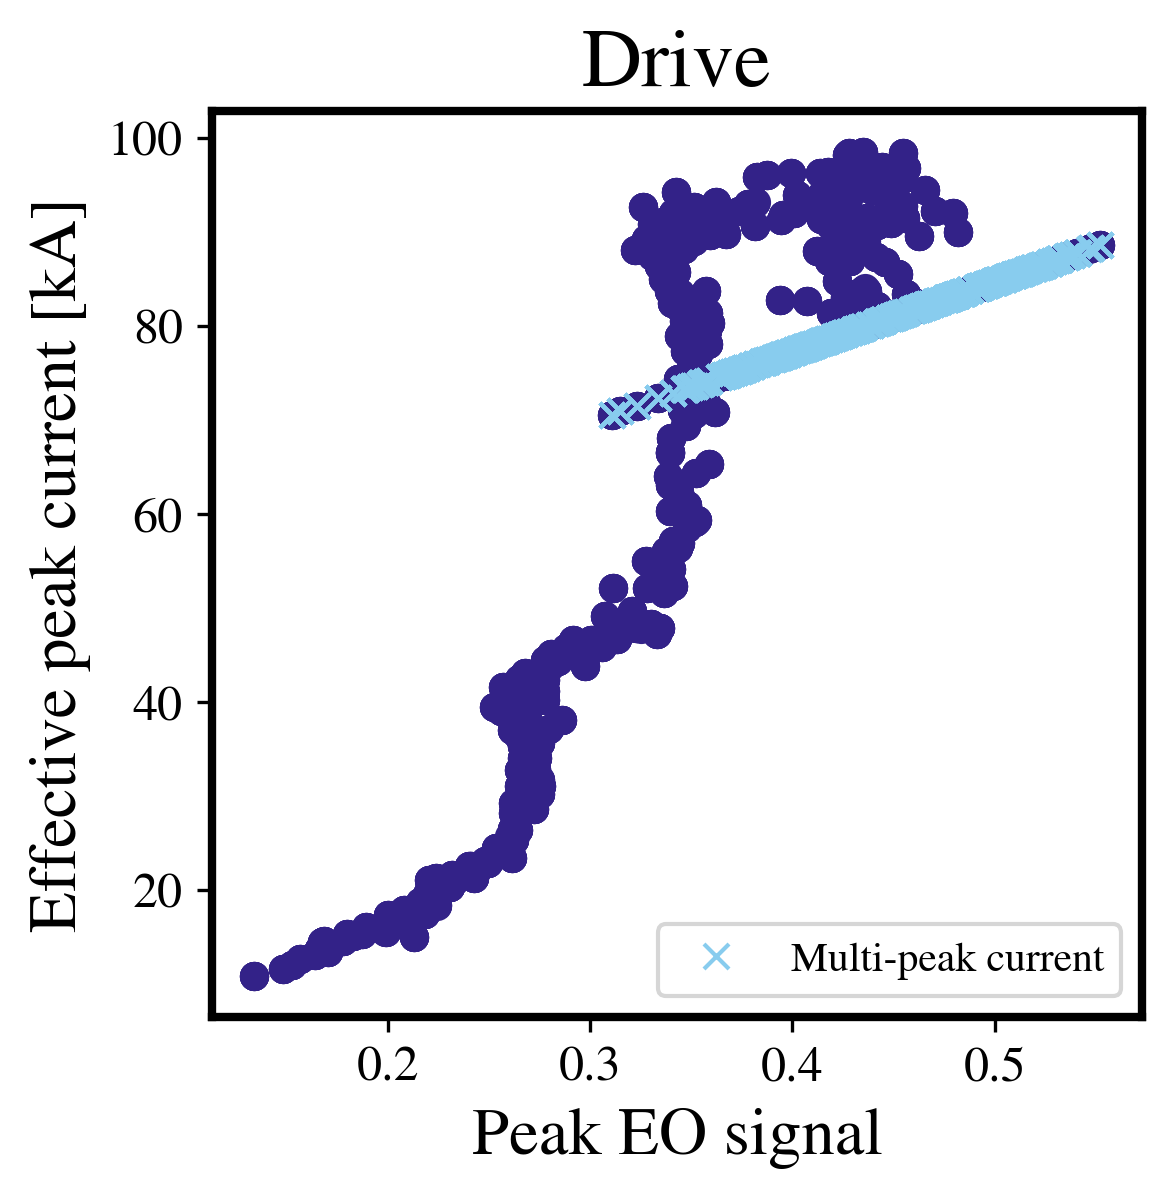

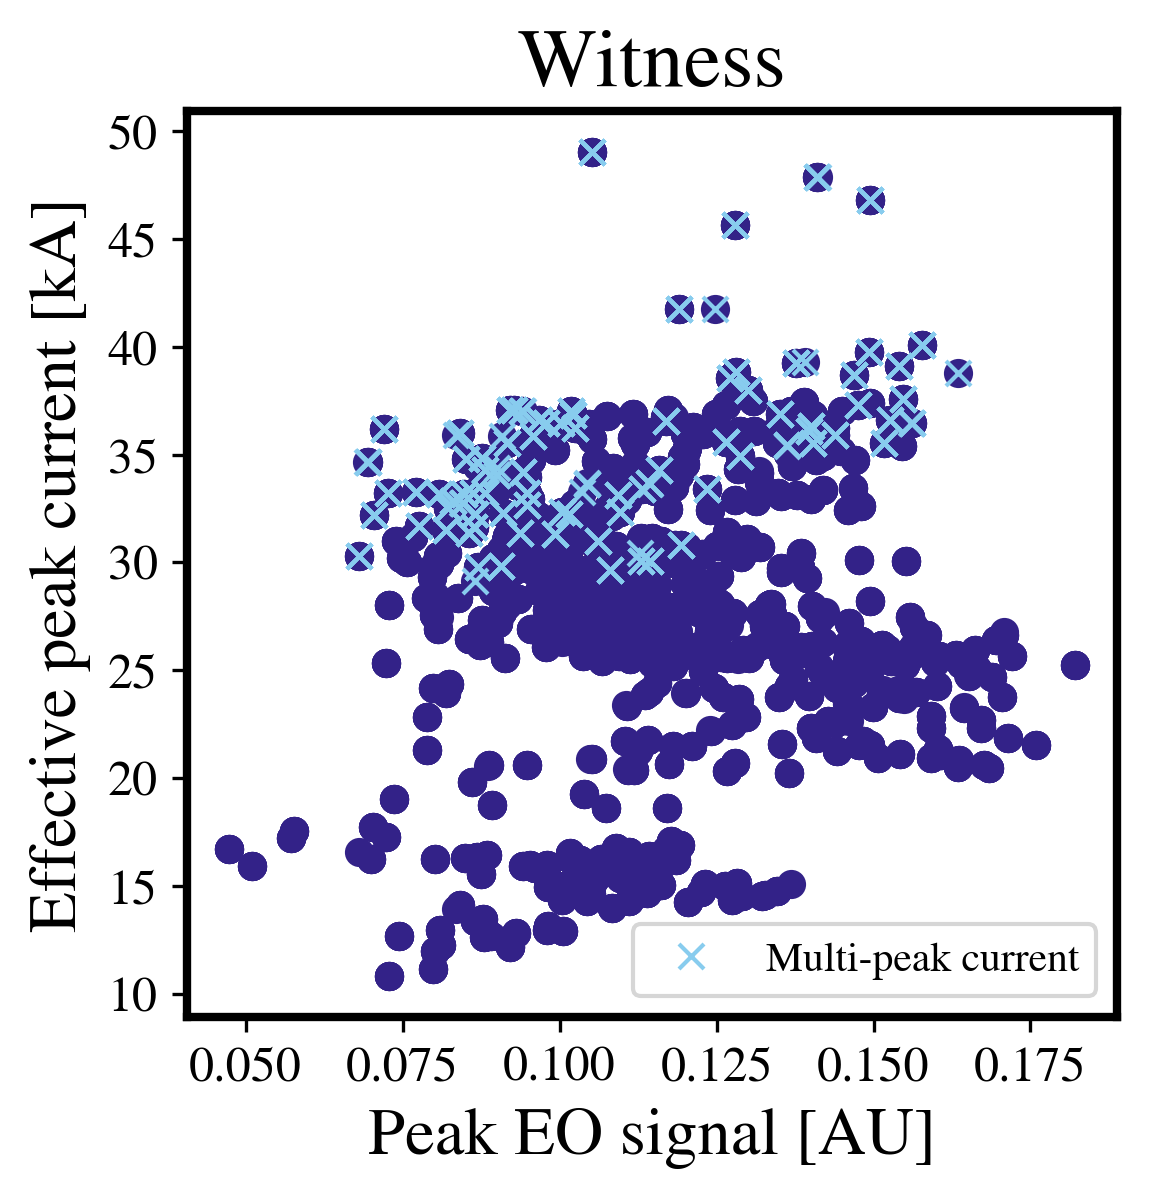

In [63]:
fig1 = plt.figure(figsize = (4,4), dpi = 300)
ax1  = fig1.gca()
ax1.set_xlabel("Peak EO signal")
ax1.set_ylabel("Effective peak current [kA]")
ax1.set_title("Drive")
ax1.plot(peak_drive_sig, sum_peaks_d, 'o')
multi_d_plot = sum_peaks_d*multi_d_ind
multi_d_plot[multi_d_plot==0] = np.nan
ax1.plot(peak_drive_sig, multi_d_plot, 'x', label = "Multi-peak current")
#ax1.plot(xdata, exp_func(xdata, *popt), label = "Exponential fit")
n1, c1 = np.polyfit(peak_drive_sig, sum_peaks_d, deg=1)
#ax1.plot(peak_drive_sig, n1*peak_drive_sig, label = "Linear fit")
ax1.legend()

fig2 = plt.figure(figsize = (4,4), dpi = 300)
ax2  = fig2.gca()
ax2.set_xlabel("Peak EO signal [AU]")
ax2.set_ylabel("Effective peak current [kA]")
ax2.set_title("Witness")
ax2.plot(peak_wit_sig, sum_peaks_w, 'o')
multi_w_plot = sum_peaks_w*multi_w_ind
multi_w_plot[multi_w_plot==0] = np.nan
ax2.plot(peak_wit_sig, multi_w_plot, 'x', label = "Multi-peak current")
ax2.legend()

plt.show()


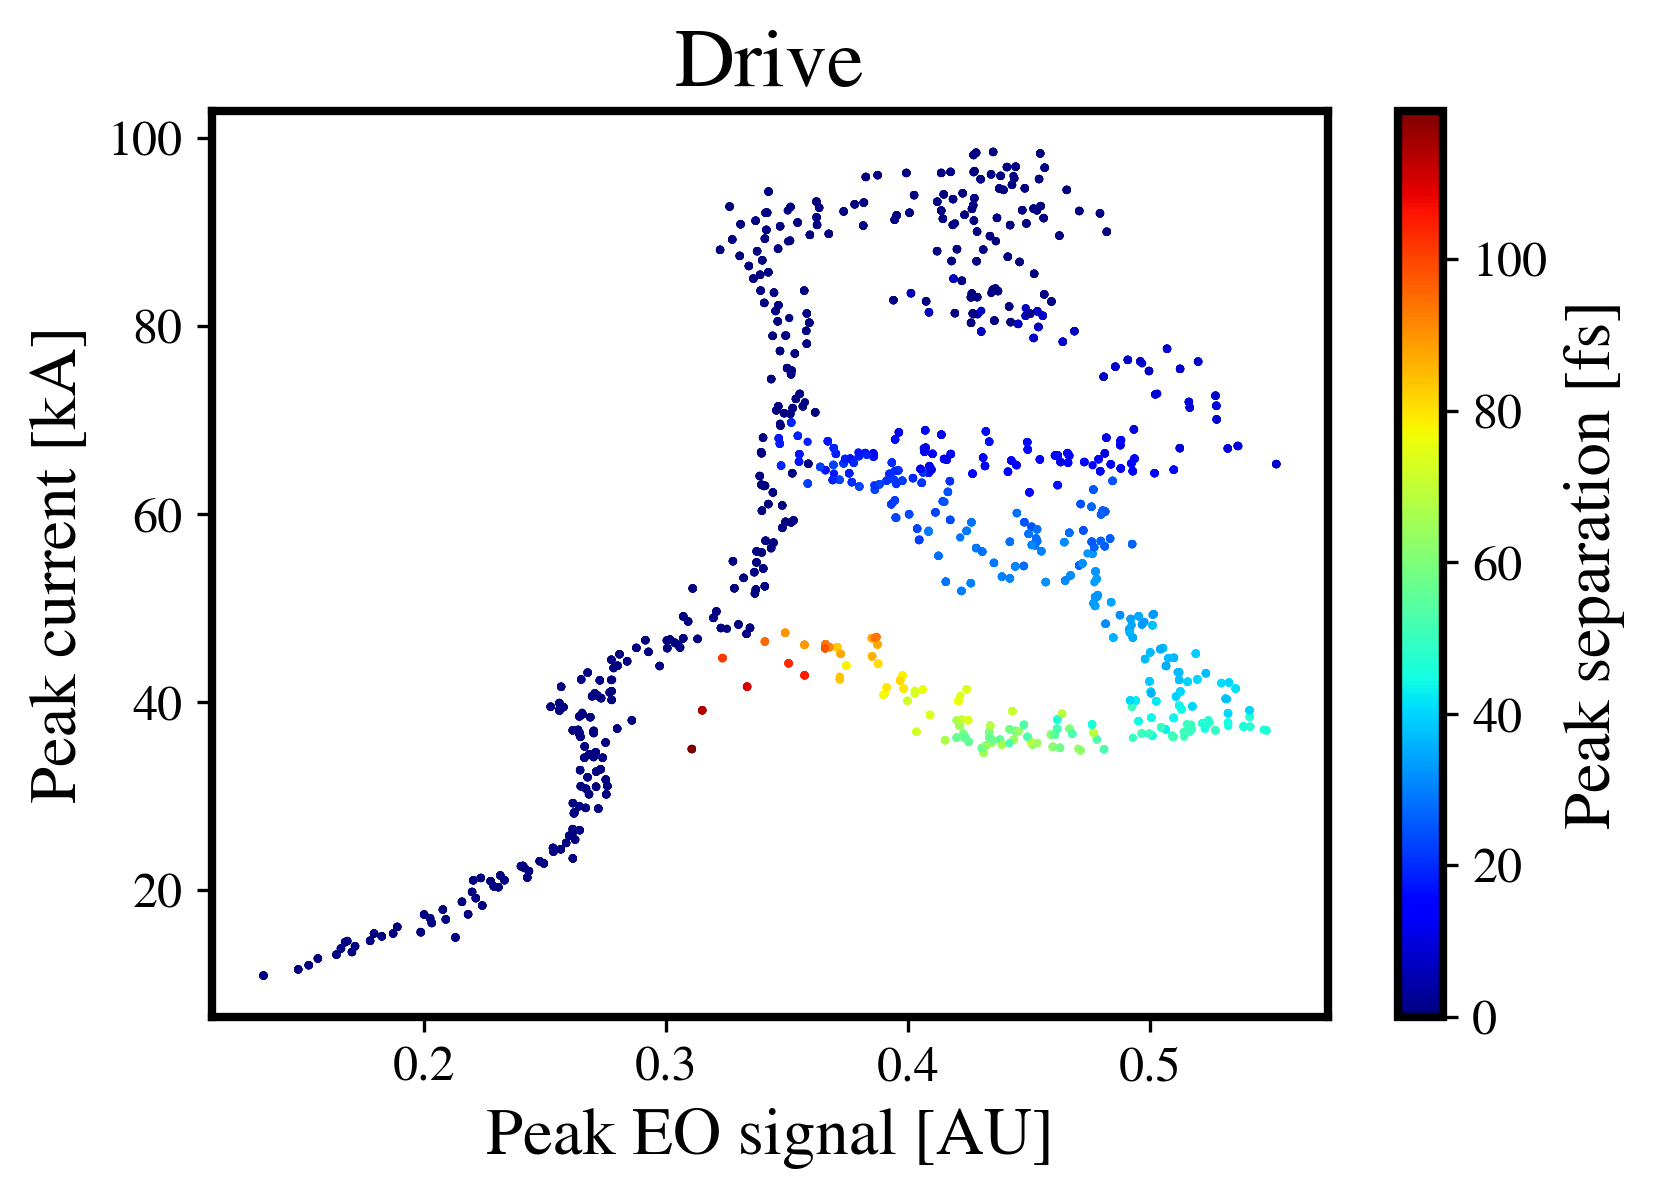

In [318]:
t_sep_d[np.isnan(t_sep_d)] = 0
fig = plt.figure(figsize = (6, 4), dpi = 300)
ax = fig.gca()
ax.set_xlabel("Peak EO signal [AU]")
ax.set_ylabel("Peak current [kA]")
ax.set_title("Drive")
img = ax.scatter(peak_drive_sig, max_dI, s= 1, c = t_sep_d*1e15, cmap = "jet")
cb = plt.colorbar(mappable = img)
cb.set_label("Peak separation [fs]")
plt.show()

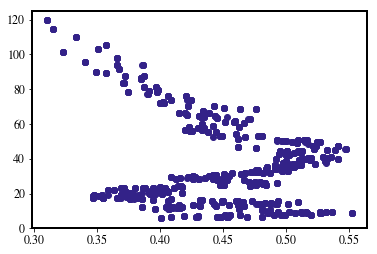

In [214]:
inds = ~np.isnan(t_sep_d)
plt.plot(peak_drive_sig[inds], t_sep_d[inds]*1e15, 'o')
plt.show()

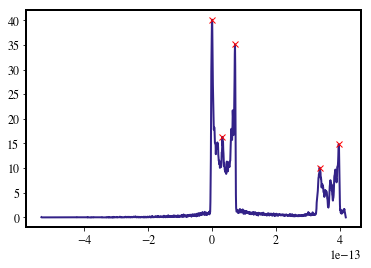

In [332]:
ind = 580
I, ti, p2p = cp.get_current(ind, cpath)
sig, tsig = eos.get_signal(ind, setup)
w_ind      = np.argmin(abs(ti - 250e-15))
max_drive  = max(I[0:w_ind])
max_wit    = max(I[w_ind:-1])
# Get peak locations
w_ind      = np.argmin(abs(ti - 250e-15))
max_drive  = max(I[0:w_ind])
max_wit    = max(I[w_ind:-1])
# Get peak locations
dlocs, dpeaks = find_peaks(I[0:w_ind], height=0.2*max_drive, prominence=5)
wlocs, wpeaks = find_peaks(I[w_ind:-1], height=0.2*max_wit, prominence=5)
wlocs = wlocs + w_ind
plt.plot(ti, I)
plt.plot(ti[dlocs], I[dlocs], 'rx')
plt.plot(ti[wlocs], I[wlocs], 'rx')
plt.show()

In [330]:
np.sum(I[dlocs])

91.59108113067259

In [303]:
# Try to indentify multi-peaked beams by the rms of their gaussian fit
def gauss_func(x, A, s):
    return A * np.exp(-x**2/s**2)
from scipy.optimize import curve_fit
N_prof  = 3135
s_drive = np.zeros(N_prof)
s_wit   = np.zeros(N_prof)
upds = int(N_prof/10)
for ind in range(N_prof):
    if (ind+1)%upds==0:
        print(ind+1)
    sig, tsig  = eos.get_signal(ind, setup)
    # Split bunches
    w_ind = np.argmin(abs(tsig-250e-15))
    xdrive = tsig[0:w_ind]*1e15
    ydrive = sig[0:w_ind]
    xwit = tsig[w_ind:-1]*1e15
    ywit = sig[w_ind:-1]
    # Recenter witness on t = 0 (easier for fitting and we only care about rms)
    xwit = xwit - xwit[np.argmax(ywit)]
    
    # fit drive
    xdrive_int = np.linspace(xdrive[0], -xdrive[0], 1000)
    f_drive    = interp1d(xdrive, ydrive, bounds_error = False, fill_value = 0)
    ydrive_int = f_drive(xdrive_int)
    p0 = [max(ydrive), 30]
    popt_d, pcov_d = curve_fit(gauss_func, xdrive_int, ydrive_int, p0)
    s_drive[ind] = popt_d[1]
    
    # fit witness
    xwit_int = np.linspace(xwit[0], -xwit[0], 1000)
    f_wit = interp1d(xwit, ywit, bounds_error = False, fill_value = 0)
    ywit_int = f_wit(xwit_int)
    p0 = [max(ywit), 30]
    popt_w, pcov_w = curve_fit(gauss_func, xwit_int, ywit_int, p0)
    s_wit[ind] = popt_w[1]
print("Done")

313
626
939
1252
1565
1878
2191
2504
2817
3130
Done


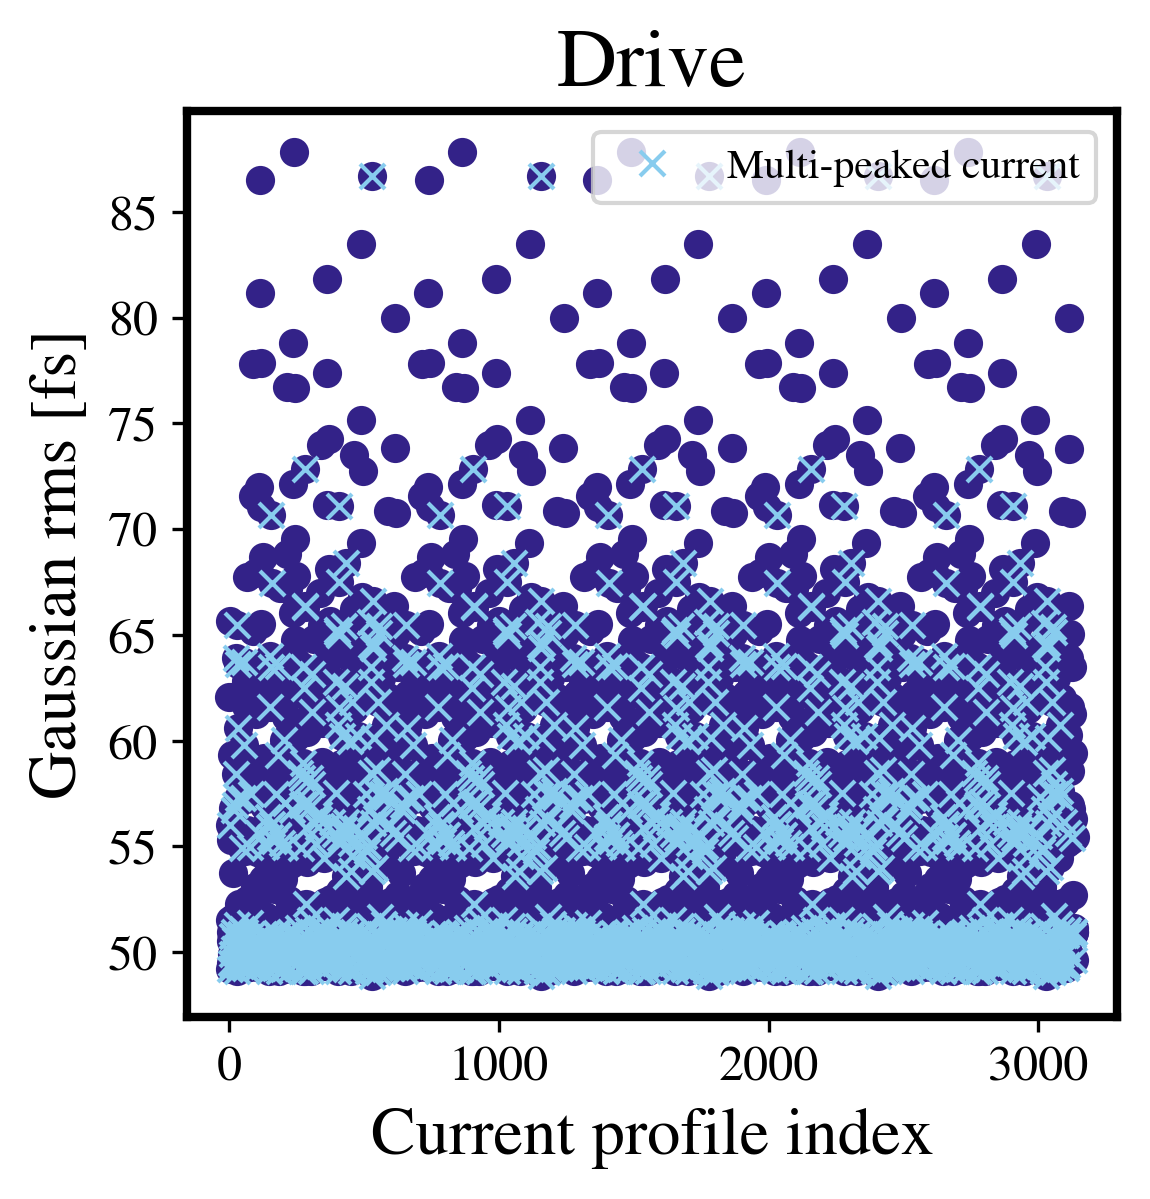

In [304]:
N_arr = np.linspace(0, N_prof, N_prof)
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Current profile index")
ax.set_ylabel("Gaussian rms [fs]")
ax.set_title("Drive")
ax.plot(N_arr, s_drive, 'o')
multi_plot = s_drive * multi_d_ind[0:N_prof]
multi_plot[multi_plot==0]=np.nan
ax.plot(N_arr, multi_plot, 'x', label = "Multi-peaked current")
ax.legend()
plt.show()

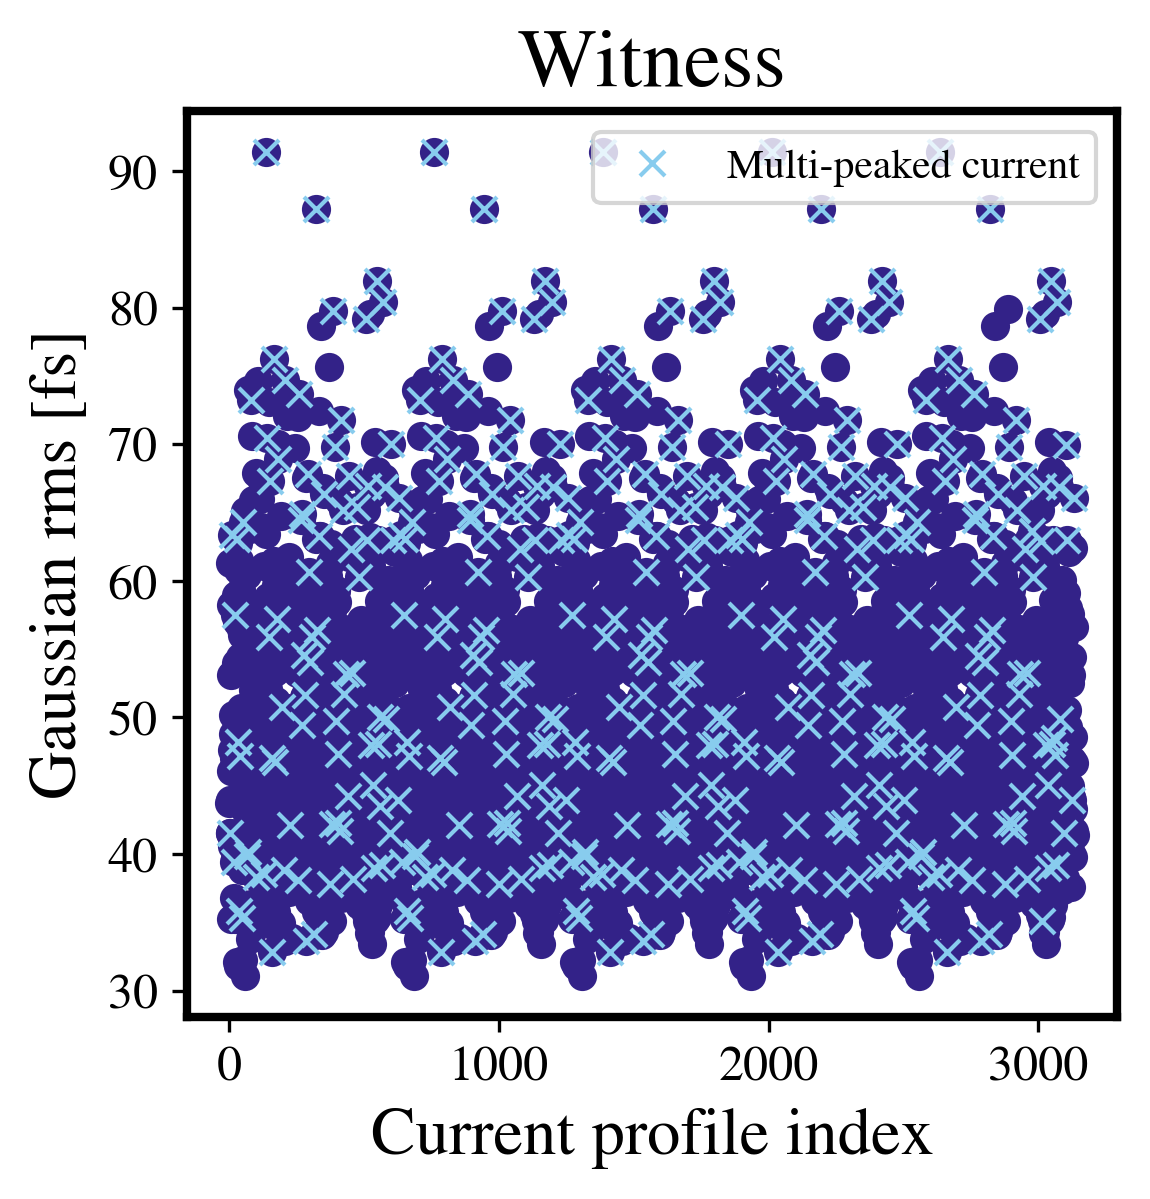

In [305]:
N_arr = np.linspace(0, N_prof, N_prof)
fig = plt.figure(figsize = (4,4), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Current profile index")
ax.set_ylabel("Gaussian rms [fs]")
ax.set_title("Witness")
ax.plot(N_arr, s_wit, 'o')
multi_plot = s_wit * multi_w_ind[0:N_prof]
multi_plot[multi_plot==0]=np.nan
ax.plot(N_arr, multi_plot, 'x', label = "Multi-peaked current")
ax.legend()
plt.show()

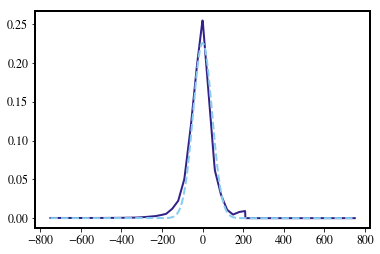

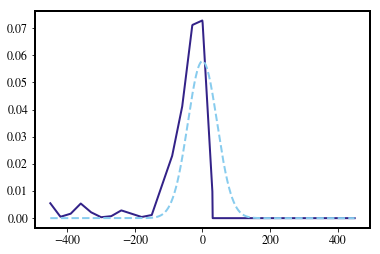

In [299]:
I, ti, p2p = cp.get_current(1, cpath)
sig, tsig  = eos.get_signal(1, setup)
# Split bunches
w_ind = np.argmin(abs(tsig-250e-15))
xdrive = tsig[0:w_ind]*1e15
ydrive = sig[0:w_ind]
xwit = tsig[w_ind:-1]*1e15
ywit = sig[w_ind:-1]
# Recenter witness on t = 0 (easier for fitting and we only care about rms)
xwit = xwit - xwit[np.argmax(ywit)]

# fit drive
xdrive_int = np.linspace(xdrive[0], -xdrive[0], 1000)
f_drive    = interp1d(xdrive, ydrive, bounds_error = False, fill_value = 0)
ydrive_int = f_drive(xdrive_int)
p0 = [max(ydrive), 30]
popt_d, pcov_d = curve_fit(gauss_func, xdrive_int, ydrive_int, p0)


# fit witness
xwit_int = np.linspace(xwit[0], -xwit[0], 1000)
f_wit = interp1d(xwit, ywit, bounds_error = False, fill_value = 0)
ywit_int = f_wit(xwit_int)
p0 = [max(ywit), 30]
popt_w, pcov_w = curve_fit(gauss_func, xwit_int, ywit_int, p0)

fig1 = plt.figure()
ax1 = fig1.gca()
ax1.plot(xdrive_int, ydrive_int)
ax1.plot(xdrive_int, gauss_func(xdrive_int, *popt_d), '--')

fig2 = plt.figure()
ax2 = fig2.gca()
ax2.plot(xwit_int, ywit_int)
ax2.plot(xwit_int, gauss_func(xwit_int, *popt_w), '--')
plt.show()